### Przygotowanie danych, analiza korelacji oraz próba przewidzenia opóźnienia dla protokołu udp

Na początku zaimportujemy przydatne oraz potrzebne biblioteki

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Następnie opuścimy dwie pierwsze kolumny które nie przydadzą się w obliczeniach (nie są liczbami, więc ciężko będzie policzyć korelację)

In [2]:
df = pd.read_csv('/home/arut3n/Documents/Studia/MagSem1/PAMSI/PAMSI-part-one/data/202301/curr_udpjitter_clean.csv')
df = df.drop(df.columns[0], axis=1)
df = df.drop(['dtime', 'target'], axis=1)
df.head(10)

,packet_size,stream_rate,duration,packets_up_sent,packets_down_sent,packets_up_recv,packets_down_recv,jitter_up,jitter_down,latency
0,160,64000,15010478,500,500,500,500,1528,724,8340
1,160,64000,15255138,500,500,500,500,1429,759,8636
2,160,64000,15048060,500,500,500,500,1228,730,7431
3,160,64000,14992462,500,500,500,500,1233,731,8332
4,160,64000,15078435,500,500,500,500,1232,711,7930
5,160,64000,15026833,500,500,500,500,1063,719,8327
6,160,64000,15016744,500,500,500,500,1358,715,7769
7,160,64000,15048972,500,500,500,500,1728,729,8736
8,160,64000,15071247,500,500,500,500,1150,726,8103
9,160,64000,16666474,500,500,500,500,1362,706,7608


Następnie obliczamy korelację pomiędzy cechami a etykietą, którą wybraliśmy:

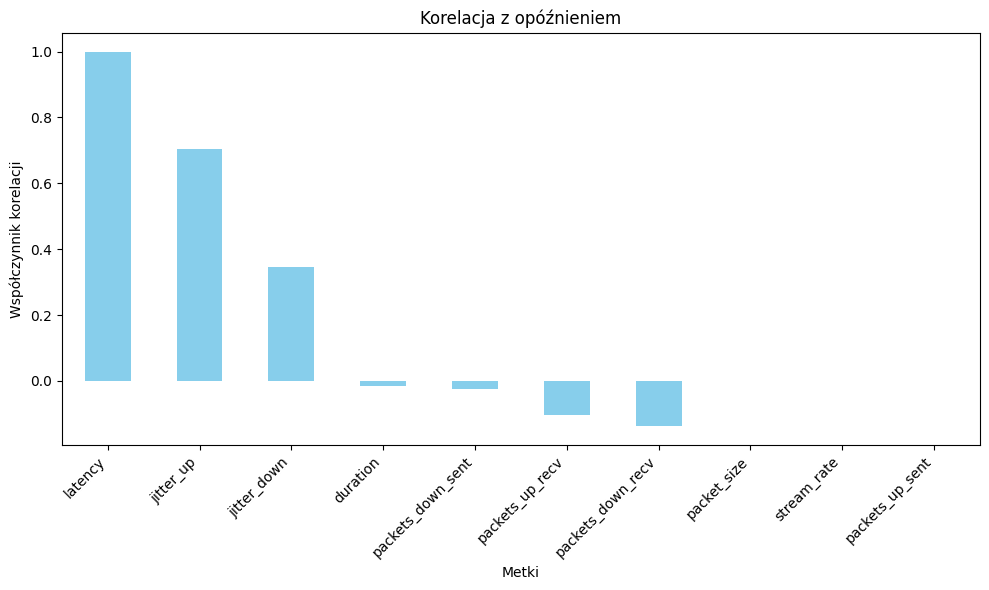

In [3]:
correlation_with_latency = df.corr()['latency'].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
correlation_with_latency.plot(kind='bar', color='skyblue')
plt.title('Korelacja z opóźnieniem')
plt.xlabel('Metki')
plt.ylabel('Współczynnik korelacji')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Oczywiście przy obliczaniu korelacji można zignorować latency, dla którego korelację obliczamy. Możemy zauważyć dość sporą zależność między jitter_up oraz w mniejszym stopniu jitter_down a latency. Pozostałe cechy wykazują małą zależność (jak w przypadku duration oraz packets_down_sent), kompletny jej brak (jak w przypadku packet_size, stream_rate_ packets_up_sent) lub odwrotną zależność, czyli wzrost odwrotnie proporcjonalny (packets_up_recv oraz packets_down_recv). Oznacza to, że wzraz ze wzrostem ilości przesyłanych pakietów maleje opóźnienie, co może być spowodowane np. retransmisją

Zatem jako że nie istnieje korelacja między latency a packet_size, stream_rate oraz packets_up_sent, pozbywamy się tych kolumn, a następnie przygotowujemy zestaw danych na podział na cechy oraz etykiety

In [4]:
#df = df.drop(['packet_size', 'stream_rate', 'packets_up_sent'], axis=1)
print(df.head(5))

feature_columns = df.columns.drop('latency')
target_column = 'latency'

X = df[feature_columns]
y = df[target_column]



   packet_size  stream_rate  duration  packets_up_sent  packets_down_sent  \
0          160        64000  15010478              500                500   
1          160        64000  15255138              500                500   
2          160        64000  15048060              500                500   
3          160        64000  14992462              500                500   
4          160        64000  15078435              500                500   

   packets_up_recv  packets_down_recv  jitter_up  jitter_down  latency  
0              500                500       1528          724     8340  
1              500                500       1429          759     8636  
2              500                500       1228          730     7431  
3              500                500       1233          731     8332  
4              500                500       1232          711     7930  


Następnie normalizujemy dane i rodzielamy je na zestaw do uczenia oraz zestaw testowy

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Będziemy teraz trenować dane na bazie modelu regresji liniowej

##### Regresja Liniowa (LinearRegression)

Model regresji liniowej zakłada liniową zależność pomiędzy zmiennymi cechami oraz zmiennymi etykiet. Jest on odpowiedni do użycia ze względu na swoją szybkość i prostotę w porównaniu z bardziej zaawansowanymi modelami, z których skorzystamy w późniejszych próbach uczenia. Niestety prostota i prędkość przynoszą ze sobą ograniczenia, jakim jest na przykład słaba efektywność w przypadku zależności nieliniowych między cechami a etykietami.

Regresja liniowa nie posiada specjalnych parametrów pozwalających manipulować uczeniem, zatem niestety takowych nie podamy.

Do implementacji wszystkich modeli wykorzystamy bibliotekę scikit-learn, która zawiera wiele przydatnych narzędzi do uczenia maszynowego oraz oceniania jakości predykcji oferowanych przez ten pakiet


Mean Squared Error: 2073371702.1019087
Mean Absolute Error: 12706.3425957461
R^2 Score: 0.5694835614835123


/tmp/ipykernel_10879/4116845308.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()],


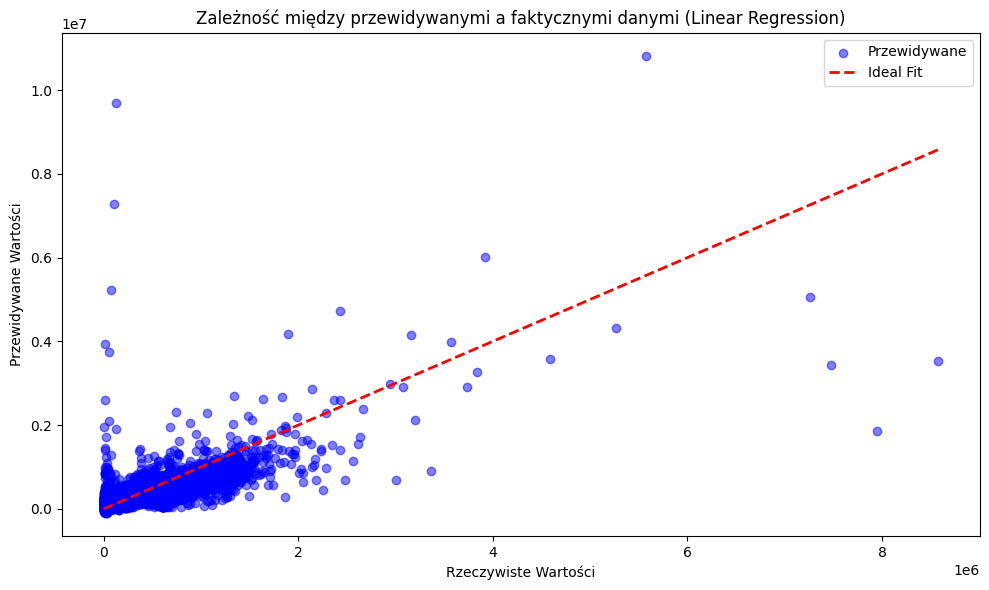

In [7]:

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

linear_predictions = linear_model.predict(X_test)
def prediction_stats(y_test, predictions):
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R^2 Score: {r2}")

def plot_actual_vs_predicted(y_actual, y_predicted, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.5, color='blue', label='Przewidywane')
    plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 
             'k--', lw=2, color='red', label='Ideal Fit')
    plt.title(title)
    plt.xlabel('Rzeczywiste Wartości')
    plt.ylabel('Przewidywane Wartości')
    plt.legend()
    plt.tight_layout()
    plt.show()

prediction_stats(y_test, linear_predictions)
plot_actual_vs_predicted(y_test, linear_predictions, 'Zależność między przewidywanymi a faktycznymi danymi (Linear Regression)')

Jak widać 

Przechodzimy teraz do uczenia na podstawie MLP Regressor, czyli modelu wykorzystujący model oparty na sieciach neuronowych. Jego przewagą nad modelem regresji liniowej jest fakt możliwości opisywania zależności nieliniowych pomiędzy cechami a etykietami oraz fakt możliwości dostrajania takiego modelu poprzez zestaw hiperparametrów. Co od ograniczeń podanego modelu, możliwość dostrajania parametrów niesie za sobą odpowiedzialność za ich odpowiednie dobieranie, gdyż błędny ich dobór może nieść za sobą pogorszenie się wyników predykcji czy też przedłużenie procesu uczenia. Kolejnym problemem może być długi czas uczenia modelu.

Parametry dobrane na ten moment to:
    random_state = 42
    max_iter = 200
    hidden_layer_sizes=(100,0)
    


In [ ]:

# MLP Regressor
mlp_model = MLPRegressor(random_state=42, max_iter=200, hidden_layer_sizes=(100, 0))
mlp_model.fit(X_train, y_train)
mlp_predictions = mlp_model.predict(X_test)


/home/arut3n/Documents/Studia/MagSem1/PAMSI/PAMSI-part-one/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error: 1672461863.1279986
Mean Absolute Error: 13072.062180217854
R^2 Score: 0.6527287778941986


/tmp/ipykernel_10879/4116845308.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()],


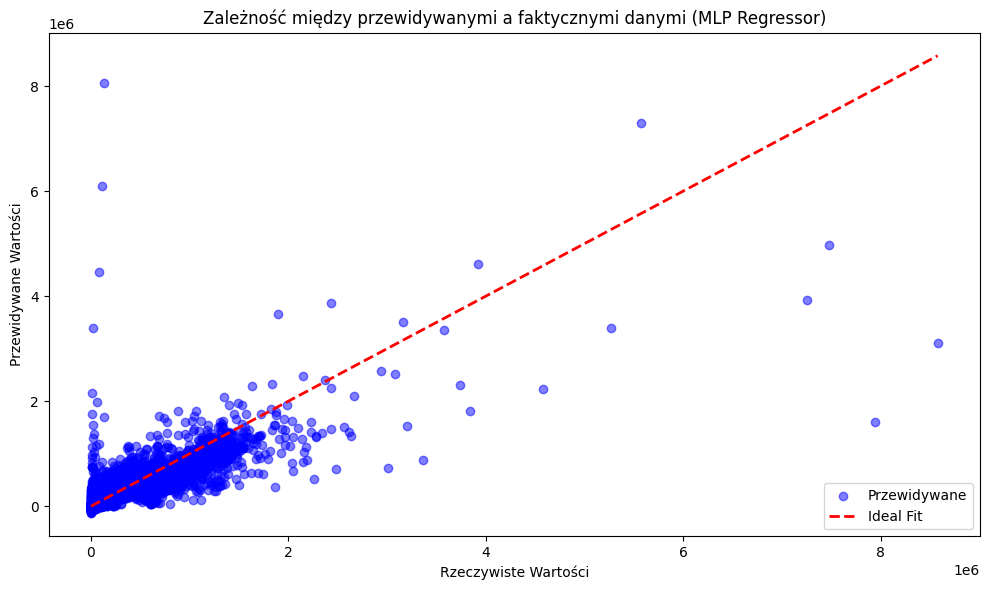

In [9]:
prediction_stats(y_test, mlp_predictions)
plot_actual_vs_predicted(y_test, mlp_predictions, 'Zależność między przewidywanymi a faktycznymi danymi (MLP Regressor)')


Jak można zauważyć powyżej, wyniki przewidywania okazały się lepsze niż dla poprzedniego modelu. Błąd średniokwadratowy wyszedł mniejszy niż w przypadku regresji liniowej, a także wskaźnik R^2 wyszedł znacznie wyższy niż w przypadku regresji liniowej. Na samym wykresie możemy też zobaczyć, że wartości przybliżyły się do linii idealnego dopasowania

Na sam koniec pozostał ostatni model czyli Random Forest. Opiera się on na budowie wielu drzew decyzyjnych i uśrednianiu otrzymywanych przez nich wyników. Plusem tego modelu jest też możliwość wykorzystania go nawet w przypadku brakujących danych. Niestety jest on wymagający obliczeniowo dla dużych zbiorów danych oraz przy zbyt dużej głębokości oraz ilości drzew może nastąpić overfitting, czyli nadmierne przystosowanie do danych testowych.

Parametry które wybrałem to maksymalna głębokość 10 oraz random_state = 42

In [ ]:

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)


In [ ]:
prediction_stats(y_test, rf_predictions)
plot_actual_vs_predicted(y_test, rf_predictions, 'Zależność między przewidywanymi a faktycznymi danymi (Random Forest)')